In [34]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle 

from ast import literal_eval
from sklearn.feature_extraction.text import TfidfVectorizer

# 'C:\Users\MrLinh\Downloads\movie_reccommender\model'
# ENV = os.getenv("MOVIE_REC","movie_recommender")
BASE_PATH = 'C:/Users/MrLinh/Downloads/movie_reccommender/model'
# BASE_PATH = os.getenv("","/movies_data") # fill in gcp server info
# GS_BUCKET = os.getenv("","") # fill in gcp bucket info

PATH_TO_IMDB = f"{BASE_PATH}/movies_data/imdb_folder"
PATH_TO_IMDB_MOVIE = f"{PATH_TO_IMDB}/movies_metadata.csv"
PATH_TO_KEYWORDS = f"{PATH_TO_IMDB}/keywords.csv"
PATH_TO_RATING = f"{PATH_TO_IMDB}/ratings_small.csv"

PATH_TO_MLENS = f""

PATH_TO_FEATURE_STORE = f"{BASE_PATH}/feature_store.csv"
PATH_TO_VECTORIZED_TEXT = f"{BASE_PATH}/vectorized_text.pickle"

# def read_data(movie_db) -> pd.DataFrame:
#     def data_path(movie_db): # reconsider
#         if movie_db == "imdb":
#             return PATH_TO_IMDB
#         else:
#             return PATH_TO_MLENS
#     data_path = data_path(movie_db) # call on both datasets
#     if os.path.exists(data_path):
#         print("Path exists.")
#     data = pd.read_csv(data_path) 
#     return data

def read_data(data_path) -> pd.DataFrame:
    data = pd.read_csv(data_path)
    return data

class FeatureBuilder:
    def __init__(self, raw_df: pd.DataFrame, lowtime = 45, hightime = 300):
        self.raw_df = raw_df[(raw_df["runtime"] >= lowtime) & (raw_df["runtime"] <= hightime)]
        self.qualified_df = pd.DataFrame() 
        self.tfidf_matrix = None

    def weighted_scores(self, percentile = 0.8): 
        minimum_vote = self.raw_df["vote_count"].quantile(percentile)
        qualified_movies = self.raw_df[self.raw_df["vote_count"] >= minimum_vote]
        average_vote = qualified_movies["vote_average"].mean()
        qualified_movies["score"] = ((qualified_movies["vote_count"]/(qualified_movies["vote_count"]+minimum_vote))*qualified_movies["vote_average"]) + ((minimum_vote/(qualified_movies["vote_count"] + minimum_vote))*average_vote)
        
        plt.hist(qualified_movies["score"], bins = 100)
        plt.grid(True)
        plt.savefig("score_distribution.png")

        self.qualified_df = qualified_movies
        return self

    def destring(self):
        self.qualified_df["genres"] = self.qualified_df["genres"].fillna('[]').apply(literal_eval)
        # self.qualified_df["genres"] = self.qualified_df["genres"]
        self.qualified_df["genres_list"] = self.qualified_df["genres"].apply(lambda x: [i["name"] for i in x] if isinstance(x,list) else [])
        self.qualified_df = self.qualified_df.explode("genres_list").drop("genres",axis=1)
        return self
    
    def vectorizer(self): # be careful when call this
        self.qualified_df["overview"] = self.qualified_df["overview"].fillna('')
        tfidf = TfidfVectorizer(stop_words="english")
        self.tfidf_matrix = tfidf.fit_transform(self.qualified_df["overview"])
        return self

def run_processing_pipeline(
        feature_builder: FeatureBuilder
) -> pd.DataFrame:
    return (
        feature_builder.weighted_scores()
        .destring()
        .vectorizer()
    )




In [99]:
movie_data = read_data(PATH_TO_IMDB_MOVIE)

C:\Users\MrLinh\AppData\Local\Temp\ipykernel_16588\3940949383.py:39: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(data_path)


In [90]:
original_data = read_data(PATH_TO_IMDB_MOVIE)

C:\Users\MrLinh\AppData\Local\Temp\ipykernel_16588\3940949383.py:39: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(data_path)


In [40]:
movie_data.head()

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0


In [61]:
pd.set_option('display.width', 300)  # Set total display width to 200 characters


In [65]:
# check if all words are meaningful, else cut 
movie_data[movie_data["overview"].apply(lambda x: len(x) == 1000 if isinstance(x,str) else False)]["overview"].iloc[0]

"Young-Goon works at manufacturing plant assembling radio’s. She also believes she is a cyborg. One day, while working at the factory, she decides to re-charge herself by slashing her wrist and implanting electrical wires into her arm. Her action gets Young-Goon a mental hospital full of bizarre characters. At New World, Young-Goon spends her time listening to the radio, talking with vending machines, and licking the terminals of 9 volt batteries. She soon encounters a guy named Il-Sun. Il-Sun is a thief of souls in the mental hospital. Young-Goon and Il-Sun soon form a strong bond as their odd personalities complements each other perfectly. Unfortunately, Young-Goon becomes gravely ill from malnutrition. Young-Goon doesn't believe cyborgs should eat human food. She soon loses most of her energy and becomes bedridden. Doctors say that Young-Goon has only a few more days to live if she continues her ways. Il-Sun must now find a way to connect to her soul and save her from imminent death

In [50]:
pd.Series(movie_data["overview"].apply(lambda x: len(x) if isinstance(x, str) else 0)).describe()

# keep max len in overview = 316

count    45466.000000
mean       316.537391
std        208.052458
min          0.000000
25%        152.000000
50%        275.000000
75%        425.000000
max       1000.000000
Name: overview, dtype: float64

In [41]:
keyword_data = read_data(PATH_TO_KEYWORDS)
keyword_data["keywords"]

0        [{'id': 931, 'name': 'jealousy'}, {'id': 4290,...
1        [{'id': 10090, 'name': 'board game'}, {'id': 1...
2        [{'id': 1495, 'name': 'fishing'}, {'id': 12392...
3        [{'id': 818, 'name': 'based on novel'}, {'id':...
4        [{'id': 1009, 'name': 'baby'}, {'id': 1599, 'n...
                               ...                        
46414               [{'id': 10703, 'name': 'tragic love'}]
46415    [{'id': 2679, 'name': 'artist'}, {'id': 14531,...
46416                                                   []
46417                                                   []
46418                                                   []
Name: keywords, Length: 46419, dtype: object

In [42]:
keyword_data["keyword_list"] = keyword_data["keywords"].fillna('[]').apply(literal_eval)
keyword_data["keyword_list"] = keyword_data["keyword_list"].apply(lambda x: [i["name"] for i in x] if isinstance(x,list) else [])
        # self.qualified_df = self.qualified_df.explode("genres_list").drop("genres",axis=1)
        

In [44]:
list1 = ['abcde']
list2 = ['01234']
' '.join(li for li in [list1, list2])

TypeError: sequence item 0: expected str instance, list found

In [67]:
keyword_data

,id,keywords,keyword_list
0,862,"[{'id': 931, 'name': 'jealousy'}, {'id': 4290,...","[jealousy, toy, boy, friendship, friends, riva..."
1,8844,"[{'id': 10090, 'name': 'board game'}, {'id': 1...","[board game, disappearance, based on children'..."
2,15602,"[{'id': 1495, 'name': 'fishing'}, {'id': 12392...","[fishing, best friend, duringcreditsstinger, o..."
3,31357,"[{'id': 818, 'name': 'based on novel'}, {'id':...","[based on novel, interracial relationship, sin..."
4,11862,"[{'id': 1009, 'name': 'baby'}, {'id': 1599, 'n...","[baby, midlife crisis, confidence, aging, daug..."
...,...,...,...
46414,439050,"[{'id': 10703, 'name': 'tragic love'}]",[tragic love]
46415,111109,"[{'id': 2679, 'name': 'artist'}, {'id': 14531,...","[artist, play, pinoy]"
46416,67758,[],[]
46417,227506,[],[]


In [71]:
rating_data.movieId.apply(type)

0         <class 'int'>
1         <class 'int'>
2         <class 'int'>
3         <class 'int'>
4         <class 'int'>
              ...      
99999     <class 'int'>
100000    <class 'int'>
100001    <class 'int'>
100002    <class 'int'>
100003    <class 'int'>
Name: movieId, Length: 100004, dtype: object

In [103]:
# movie_data.drop(movie_data[movie_data["id"] == '1997-08-20'].index, inplace=True)
movie_data[movie_data["id"].apply(lambda x: '-' in x)]

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count


In [101]:
movie_copy = movie_data.copy()

In [102]:
movie_data.drop(movie_data[movie_data["id"].apply(lambda x: '-' in x)].index,inplace=True)


In [104]:
movie_data.id = movie_data.id.astype(int)

In [68]:
keyword_data["id"].apply(type)

0        <class 'int'>
1        <class 'int'>
2        <class 'int'>
3        <class 'int'>
4        <class 'int'>
             ...      
46414    <class 'int'>
46415    <class 'int'>
46416    <class 'int'>
46417    <class 'int'>
46418    <class 'int'>
Name: id, Length: 46419, dtype: object

In [98]:
movie_data

,id
0,862
1,8844
2,15602
3,31357
4,11862
...,...
45461,439050
45462,111109
45463,67758
45464,227506


In [105]:
pd.merge(movie_data, keyword_data, on="id")
        # self.raw_df = pd.merge(self.raw_df, raw_ratings, lef_on="id", right_on="movieId")

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,keywords,keyword_list
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0,"[{'id': 931, 'name': 'jealousy'}, {'id': 4290,...","[jealousy, toy, boy, friendship, friends, riva..."
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0,"[{'id': 10090, 'name': 'board game'}, {'id': 1...","[board game, disappearance, based on children'..."
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0,"[{'id': 1495, 'name': 'fishing'}, {'id': 12392...","[fishing, best friend, duringcreditsstinger, o..."
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0,"[{'id': 818, 'name': 'based on novel'}, {'id':...","[based on novel, interracial relationship, sin..."
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0,"[{'id': 1009, 'name': 'baby'}, {'id': 1599, 'n...","[baby, midlife crisis, confidence, aging, daug..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46477,False,NaN,0,"[{'id': 18, 'name': 'Drama'}, {'id': 10751, 'n...",http://www.imdb.com/title/tt6209470/,439050,tt6209470,fa,رگ خواب,Rising and falling between a man and woman.,...,90.0,"[{'iso_639_1': 'fa', 'name': 'فارسی'}]",Released,Rising and falling between a man and woman,Subdue,False,4.0,1.0,"[{'id': 10703, 'name': 'tragic love'}]",[tragic love]
46478,False,NaN,0,"[{'id': 18, 'name': 'Drama'}]",NaN,111109,tt2028550,tl,Siglo ng Pagluluwal,An artist struggles to finish his work while a...,...,360.0,"[{'iso_639_1': 'tl', 'name': ''}]",Released,NaN,Century of Birthing,False,9.0,3.0,"[{'id': 2679, 'name': 'artist'}, {'id': 14531,...","[artist, play, pinoy]"
46479,False,NaN,0,"[{'id': 28, 'name': 'Action'}, {'id': 18, 'nam...",NaN,67758,tt0303758,en,Betrayal,"When one of her hits goes wrong, a professiona...",...,90.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,A deadly game of wits.,Betrayal,False,3.8,6.0,[],[]
46480,False,NaN,0,[],NaN,227506,tt0008536,en,Satana likuyushchiy,"In a small town live two brothers, one a minis...",...,87.0,[],Released,NaN,Satan Triumphant,False,0.0,0.0,[],[]


In [43]:
keyword_data["keyword_list"]

0        [jealousy, toy, boy, friendship, friends, riva...
1        [board game, disappearance, based on children'...
2        [fishing, best friend, duringcreditsstinger, o...
3        [based on novel, interracial relationship, sin...
4        [baby, midlife crisis, confidence, aging, daug...
                               ...                        
46414                                        [tragic love]
46415                                [artist, play, pinoy]
46416                                                   []
46417                                                   []
46418                                                   []
Name: keyword_list, Length: 46419, dtype: object

In [39]:
rating_data = read_data(PATH_TO_RATING)
rating_data.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


In [ ]:
movie_data["genres"].fillna([])

C:\Users\MrLinh\AppData\Local\Temp\ipykernel_16588\3940949383.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  qualified_movies["score"] = ((qualified_movies["vote_count"]/(qualified_movies["vote_count"]+minimum_vote))*qualified_movies["vote_average"]) + ((minimum_vote/(qualified_movies["vote_count"] + minimum_vote))*average_vote)
C:\Users\MrLinh\AppData\Local\Temp\ipykernel_16588\3940949383.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.qualified_df["genres"] = self.qualified_df["genres"].fi

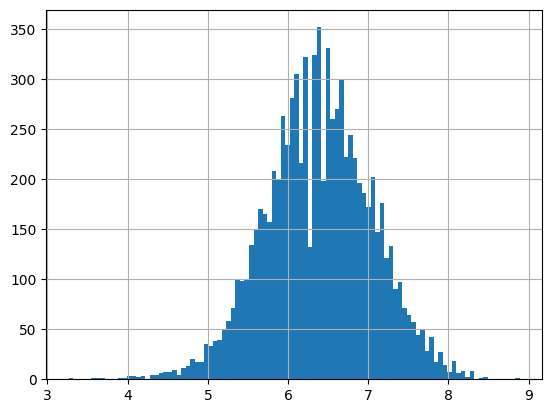

In [35]:
intermediate = run_processing_pipeline(FeatureBuilder(movie_data))

In [36]:
intermediate.qualified_df.head()

,adult,belongs_to_collection,budget,homepage,id,imdb_id,original_language,original_title,overview,popularity,...,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,score,genres_list
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.946943,...,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0,7.686300,Animation
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.946943,...,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0,7.686300,Comedy
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.946943,...,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0,7.686300,Family
1,False,NaN,65000000,NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,17.015539,...,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0,6.887786,Adventure
1,False,NaN,65000000,NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,17.015539,...,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0,6.887786,Fantasy


In [37]:
intermediate.tfidf_matrix

<21346x27622 sparse matrix of type '<class 'numpy.float64'>'
	with 550645 stored elements in Compressed Sparse Row format>

In [18]:
if __name__ == "__main__":
    movie_data = read_data(PATH_TO_IMDB_MOVIE)
    intermediate = run_processing_pipeline(movie_data)
    feature_store = intermediate.qualified_df
    tfdif_matrix = intermediate.tfidf_matrix
    feature_store.to_csv(PATH_TO_FEATURE_STORE) 
    with open(PATH_TO_VECTORIZED_TEXT, "wb") as file: 
        pickle.dump(tfdif_matrix, file)

C:/Users/MrLinh/Downloads/movie_reccommender/model/movies_data/imdb_folder/movies_metadata.csv
   adult                              belongs_to_collection    budget  \
0  False  {'id': 10194, 'name': 'Toy Story Collection', ...  30000000   
1  False                                                NaN  65000000   
2  False  {'id': 119050, 'name': 'Grumpy Old Men Collect...         0   
3  False                                                NaN  16000000   
4  False  {'id': 96871, 'name': 'Father of the Bride Col...         0   

                                              genres  \
0  [{'id': 16, 'name': 'Animation'}, {'id': 35, '...   
1  [{'id': 12, 'name': 'Adventure'}, {'id': 14, '...   
2  [{'id': 10749, 'name': 'Romance'}, {'id': 35, ...   
3  [{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...   
4                     [{'id': 35, 'name': 'Comedy'}]   

                               homepage     id    imdb_id original_language  \
0  http://toystory.disney.com/toy-story    862  tt

C:\Users\MrLinh\AppData\Local\Temp\ipykernel_16588\1017554001.py:40: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(data_path)


AttributeError: 'DataFrame' object has no attribute 'weighted_scores'